In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

pd.options.display.max_rows = 500
pd.options.display.max_columns = 200

import sys
sys.path.append('../src/')

idxs = pd.IndexSlice

In [3]:
taz = gpd.read_file('../data/TAZ/Zonas.shp').drop(columns='ESTADO')

In [4]:
from od import (
    load_od, plot_trips, insert_trip, fix_od_chains, check_od_chains,
    check_overlap, get_purpose_tmat, index_next_trip, index_prev_trip,
    fix_home_loc, build_people_table, build_household_table, build_trips
)

In [481]:
%%time
od_df = load_od('../data/OD_Survey/pimus_final.csv')

trips, legs_wide = build_trips(od_df)
people = build_people_table(od_df, trips)
households = build_household_table(od_df, people)

trips['ntrip'] = np.nan
trips.loc[trips.Motivo=='estudios', 'ntrip'] = trips.loc[trips.Motivo=='estudios'].groupby(['HOGAR', 'HABITANTE']).Motivo.transform('rank', method='first')
trips.loc[trips.Motivo=='trabajo', 'ntrip'] = trips.loc[trips.Motivo=='trabajo'].groupby(['HOGAR', 'HABITANTE']).Motivo.transform('rank', method='first')

88.39450686641698% of households have been ajusted.
0.7790262172284644 of households are missing members above 6 years of age.
CPU times: user 18.7 s, sys: 512 ms, total: 19.2 s
Wall time: 19.3 s


In [482]:
from od import personas_as_od, viviendas_as_od

personas = personas_as_od(Path('../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Personas19.CSV'))
viviendas = viviendas_as_od(Path('../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Viviendas19.CSV'), personas, households)

In [484]:
households_models = (
    pd.DataFrame(index=households.index)
    .assign(
        HouseholdId=range(len(households)),
        HouseholdZone=households.TAZ,
        ExpansionFactor=trips.groupby('HOGAR').FACTOR.mean().reindex(households.index).fillna(1),
        NumberOfPersons=households.NUMPERS,
        DwellingType=households.CLAVIVP.map({'SinNumInt': 1, 'ConNumInt': 2}),
        Vehicles=households.NumberOfVehicles.astype(int),  # Auto+Pickup+Moto
        IncomeClass=households.NSE.map({'E': 1, 'D': 2, 'D+': 3, 'C-': 4, 'C': 4, 'C+': 5, 'A/B': 6, np.nan: 7})
    )
)

In [485]:
people_models = (
    pd.DataFrame(index=people.index)
    .assign(
        HouseholdId=households_models.HouseholdId.reindex(people.index, level=0),
        PersonNumber=people.index.get_level_values(1),
        Age=people.Edad,
        Sex=people.SEXO,
        License=(people.Edad >= 18).map({True: 'Y', False: 'N'}),
        TransitPass='N',
        EmploymentStatus=people.CONACT.map(
            {
                'Trabajó': 'F', 
                'No trabaja': 'O', 
                'Se dedica a los quehaceres del hogar': 'O', 
                'Es pensionada(o) o jubilada(o)': 'O'
            }
        ).mask(people.informal==1, 'P'),
        Occupation=people.ACTIVIDADES_C.map(
            {
                'Blanco por pase': 'O',
                'servicios': 'P',
                'industria manufacturera': 'M',
                'comercio': 'S',
                'construcción': 'M',
                'otro': 'G',
                'transporte y comunicaciones': 'G',
                'gobierno': 'G',
                'agricultura y ganadería': 'G',
                'minería': 'G',
            }
        ).fillna('G'),
        FreeParking='O',
        StudentStatus=people.ASISTEN.map({'No': 'O', 'Sí': 'S'}),
        EmploymentZone=people.TAZ_TRAB.replace('Blanco por pase', 0).fillna(0).astype(int),
        SchoolZone=people.TAZ_ASI.replace('Blanco por pase', 0).fillna(0).astype(int),
        ExpansionFactor=households_models.ExpansionFactor.reindex(people.index, level=0)
    )
)

In [486]:
purp_dest = trips.Motivo.map(
    {
        'regreso a casa': 'H',
        'trabajo': 'W',
        'estudios': 'S',
        'compras': 'M',
        'acompañar / recoger': 'F',
        'recreación': 'E',
        'otro': 'O',
        'salud': 'O'
    }
)

purp_orig = pd.Series('', index=purp_dest.index)
purp_orig.loc[idxs[:, :, 1]] = trips.loc[idxs[:, :, 1], 'Origen'].map({'Hogar': 'H', 'Otro': 'O'})
pidx = index_prev_trip(purp_dest.loc[idxs[:, :, 2:]].index)
purp_orig.loc[idxs[:, :, 2:]] = purp_dest.loc[pidx].values

purp_dest = purp_dest.mask((trips.ntrip > 1) & (purp_dest == 'W'), 'R')
purp_dest = purp_dest.mask((trips.ntrip > 1) & (purp_dest == 'S'), 'C')

trips_models = (
    pd.DataFrame(index=trips.index)
    .assign(
        HouseholdId=households_models.HouseholdId.reindex(trips.index, level=0),
        PersonNumber=people_models.PersonNumber.reindex(trips.index),
        TripNumber=trips.index.get_level_values(2),
        StartTime=(trips.fecha_inicio.dt.hour*100 + trips.fecha_inicio.dt.minute).astype(int),
        Mode=trips['Modo Agrupado'].map({
            'a pie (caminando)': 'W',
            'automóvil (conductor)': 'D',
            'tpub': 'B',
            'automóvil (pasajero)': 'P',
            'transporte de personal': 'O',
            'taxi': 'T',
            'transporte escolar': 'S',
            'uber, cabify , didi o similar': 'U',
            'modos combinados con tpub': 'B',
            'bicicleta': 'C',
            'motocicleta': 'M',
            'otro': 'O',
            'modos combinados sin tpub': '9',
            'motocicleta (conductor)': 'M',
            'transporte público': 'B',
            'patineta': 'O'
        }),
        PuposeOrigin=purp_orig,
        ZoneOrigin=trips.ZonaOri.astype(int),
        PurposeDestination=purp_dest,
        ZoneDestination=trips.ZonaDest.astype(int)
    )
)
trips_models.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 91256 entries, ('000002-14', 1, 1) to ('M9766-6', 5, 2)
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   HouseholdId         91256 non-null  int64 
 1   PersonNumber        91256 non-null  int64 
 2   TripNumber          91256 non-null  int64 
 3   StartTime           91256 non-null  int64 
 4   Mode                91256 non-null  object
 5   PuposeOrigin        91256 non-null  object
 6   ZoneOrigin          91256 non-null  int64 
 7   PurposeDestination  91256 non-null  object
 8   ZoneDestination     91256 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 9.3+ MB


In [487]:
households_models.to_csv('../output/od_households.csv', index=False)
people_models.to_csv('../output/od_people.csv', index=False)
trips_models.to_csv('../output/od_trips.csv', index=False)

### Informal/Formal Model

In [483]:
# Import enoe data base to train
enoe = pd.read_csv('../data/ENOE/enoe_clean.csv', index_col=0)
y = enoe['informal']
X = enoe.drop(columns='informal').pipe(
    lambda df: df.assign(
        sector=df.sector.str.lower(),
        escolaridad=df.escolaridad.map({
            'Primaria o Secundaria': 'Básica',
            'Carrera técnica o preparatoria': 'MediaSup',
            'Sin Instrucción': 'Sin Educación',
            'Licenciatura': 'Licenciatura',
            'Postgrado': 'Postgrado'
        })
    )
)

# Model
# Train the winning model from before
# We are adjusting hyperparameters again
sys.path.append('../../informal_jobs/')
from models_grids import models_LR, models_RF, models_GB, models_SVC, models_KNN

models = models_LR | models_RF | models_GB | models_SVC | models_KNN
model = models['GB_ed_num']['model']
model.set_params(
    classifier__learning_rate=0.1,
    classifier__max_leaf_nodes=5,
    preprocessor__od_encoder__unknown_value=None,
    preprocessor__od_encoder__handle_unknown='error',
)
model.fit(X, y);

# Process cleaned OD survey into expected model shape
od_model = (
    people.query("CONACT=='Trabajó'")[['SEXO', 'SITTRA', 'Edad', 'ACTIVIDADES_C', 'EDUC2', 'MUN']].copy()
    .pipe(
        lambda df: df.assign(
            genero=df.SEXO.map({'M': 'H', 'F': 'F'}),
            ocupacion=df.SITTRA.map(
                {
                    'empleada(o) u obrera(o)': 'trabajador',
                    'trabajador(a) por cuenta propia': 'independiente',
                    'patrón(a) o empleador(a)': 'otro',
                }
            ).fillna('otro'),
            edad_num=df.Edad,
            sector=df.ACTIVIDADES_C.fillna('otro'),
            escolaridad=df.EDUC2.fillna('Básica'),
            municipio=df.MUN.str.lower().replace(
                [
                    'cadereyta jiménez', 'abasolo', 'el carmen',
                    'general escobedo', 'ciénega de flores', 
                    'garcía', 'general zuazua', 'juárez',
                    'pesquería', 'salinas victoria',
                    'san nicolás de los garza', 'santa catarina',
                    'san pedro garza garcía',
                ],
                [
                    'cadereyta', 'otro', 'carmen', 'escobedo', 
                    'flores', 'garcia', 'zuazua', 'juarez', 'otro', 
                    'salinas', 'san_nicolas', 'santa_catarina',
                    'san_pedro'
                ]
            )
        )
    )
    .drop(columns=['SEXO', 'SITTRA', 'Edad', 'ACTIVIDADES_C', 'EDUC2', 'MUN'])
)

# Predict formal/informal labels
od_model['informal'] = model.predict(od_model)

people['informal'] = od_model['informal'].reindex(people.index).fillna('Blanco por pase')

### Trip origin destination purpose

In [ ]:
# Check overlaping trips
# This are trips that begin before the last one ends
overlaping_trips = check_overlap(trips)
overlaping_trips.shape

In [ ]:
# Check Zona chains
def check_taz_chains(trips):
    # Check in prev destination is current origin
    # current orgin starts at trips > 2
    idxs = pd.IndexSlice
    cur_idx = trips.loc[idxs[:, :, 2:]].index
    prev_idx = pd.MultiIndex.from_arrays([
        cur_idx.get_level_values(0),
        cur_idx.get_level_values(1),
        cur_idx.get_level_values(2) - 1
    ])

    no_chain = (
        trips.loc[cur_idx].ZonaOri != trips.loc[prev_idx].ZonaDest.values
    ).pipe(lambda s: s[s]).index.droplevel(2).unique()

    return no_chain

print(check_taz_chains(trips).shape)

In [ ]:
# Not all inhabitants are numerated sequentially

not_first_one = []
not_sequential = []
for i, (idx, df) in enumerate(od_df.groupby(['HOGAR'])):
    hogar = idx[0]
    habitantes = df.index.get_level_values(1).unique()

    if habitantes.min() != 1:
        not_first_one.append(hogar)
    if np.sum(np.diff(habitantes) != 1) > 0:
        not_sequential.append(hogar)

print(len(not_first_one))
print(len(not_sequential))

In [ ]:
# Not all trips are numerated sequentially

zero_redundant = []
not_sequential = []
for i, (idx, df) in enumerate(od_df.groupby(['HOGAR', 'HABITANTE'])):
    hogar = idx[0]
    habitante = idx[1]
    viajes = df.index.get_level_values(2)

    assert viajes.nunique() == len(viajes), idx
    if viajes.min() == 0:
        if len(viajes) == 1:
            # This inhabitant does not travel
            continue
        else:
            zero_redundant.append((*idx, 0))
            # df = df.drop(index=(*idx, 0))
            viajes = viajes.drop(0)

    if (viajes.min() != 1) or (viajes.max() != len(viajes)) or (viajes.nunique() != len(viajes)):
            not_sequential.append(idx)
print(len(zero_redundant))
print(len(not_sequential))

### Legs table

In [ ]:
from od import build_legs
legs1, legs2, legs3, legs4, legs5, legs6 = build_legs(legs_wide)
legs1['agrupado'] = trips.loc[legs1.index, 'Modo Agrupado']

In [ ]:
legs = build_legs(legs_wide)

In [ ]:
pd.crosstab(legs1.Transp, legs1.TipoTransp, dropna=False)

In [ ]:
pd.crosstab(legs1.query("TipoTransp == 'particular' & agrupado == 'modos combinados con tpub'").Transp, legs1.query("TipoTransp == 'particular'  & agrupado == 'modos combinados con tpub'").TpoAbordo)

In [ ]:
cond = (
    (legs1.Transp == 'a pie (caminando)')
    & (legs1.TipoTransp == 'particular')
   # & (legs1.TpoAbordo > 0)
)

In [ ]:
viv_df.loc[legs1.loc[cond].index.get_level_values(0)]

In [ ]:
legs1.loc[cond]

In [ ]:
legs2.loc[legs1.loc[cond].index].query('TipoTransp != "público"')

In [ ]:
legs3.loc[legs2.loc[legs1.loc[cond].index].query('TipoTransp != "público"').index]

In [ ]:
legs4.loc['60971_4']

In [ ]:
legs1.loc[legs2.query("Transp == 'transporte público'").index]

In [ ]:
legs3.query("Transp.notnull() & TipoTransp.isna()")

In [ ]:
def check_leg(r):
    if r.Tpo_Caminata == 0:
        assert r.TpoAbordo > 0
    if r.TpoAbordo == 0:
        assert r.Tpo_Caminata > 0
    #assert r.Tpo_Caminata == 0 or r.TpoAbordo == 0, r.name

In [ ]:
def combine_transp(a):
    ss = '-'.join(s for s in sorted(a))
    if 'TPUB' in ss and '-' in ss:
        ss = 'TPUB+'
    #elif '-' in ss:
    #    ss = 'comb'
    return ss

In [ ]:
idx = legs.groupby(['HOGAR', 'HABITANTE', 'VIAJE']).Transp.unique().apply(combine_transp).pipe(lambda s: s[s=='caminando']).index

In [ ]:
legs.TipoTransp.value_counts()

In [ ]:
legs.TipoTransp.str.strip().str.lower().value_counts()

In [ ]:
legs.reset_index(level=3).loc[(trips.loc[idx, 'Modo Agrupado'] == 'TPUB').pipe(lambda s: s[s]).index]

In [ ]:
pd.crosstab(
    legs.groupby(['HOGAR', 'HABITANTE', 'VIAJE']).Transp.unique().apply(combine_transp),
    trips['Modo Agrupado'].replace(
        ['Automóvil (Conductor)', 'Automóvil (pasajero)'], ['Auto', 'Auto']
    )
)

In [ ]:
legs.loc[idxs[:,:,:,1], 'Transp']

In [ ]:
pd.crosstab(legs.loc[idxs[:,:,:,1], 'Transp'].droplevel(3), trips['Modo Agrupado'])

In [ ]:
np.sort(tramo_df.Transp_O.dropna().replace(
    {
        0.0: '0',
        'Ambulancias': 'Otro',
        'Auto del vecino': 'Automóvil (pasajero)',
        'Auto particular acompañando a la familia': 'Automóvil (pasajero)',
        'Autobus': 'Autobus',
        'Automóvil de la empresa': 'Automóvil (conductor)',
        'Automóvil del papá acompaño de compras a la familia': 'Automóvil (pasajero)',
        'Caballo': 'Otro',
        'Camineta': 'Automóvil (conductor)',
        'Camioneta': 'Automóvil (conductor)',
        'Camioneta (conductor)': 'Automóvil (conductor)',
        'Camioneta (pasajero)': 'Automóvil (pasajero)',
        'Camioneta del trabajo': 'Automóvil (conductor)',
        'Camión': 'Camión Urbano',
        'Camión conductor': 'Autobus (chofer)',
        'Camión de carga': 'Otro',
        'Camión de la Empresa': 'Transporte de personal',
        'Camión de redilas': 'Transporte de personal',
        'Camión descarga': 'Otro',
        'Carrito acondicionado para sus traslados': 'Otro',
        'Carrito de tres llantas que le acondicionaron para sus traslados ya que parte de su cuerpo está inmóvil': 'Otro',
        'Carro': 'Automóvil (conductor)',
        'Carro Colectivo': 'Automóvil (pasajero)',
        'Carro colectivo': 'Automóvil (pasajero)',
        'Carro conductor Didi': 'Taxi App (chofer)',
        'Chofer de taxi': 'Taxi Sitio (chofer)',
        'Chofer de transporte de personal': 'Transporte de personal (chofer)',
        'Chofer del transporte de personal': 'Transporte de personal (chofer)',
        'Chófer de Uber': 'Taxi App (chofer)',
        'Chófer de camión de personal': 'Transporte de personal (chofer)',
        'Chófer de casa donde presta el servicio la baja hace 15 min de traslado para dejarla en parada de camión': 'Automóvil (pasajero)',
        'Conductor De transported De personal': 'Transporte de personal (chofer)',
        'Chófer de transporte escolar': 'Transporte escolar (chofer)',
        'Condujo taxi': 'Taxi Sitio(chofer)',
        'Conductor Uber': 'Taxi App (chofer)',
        'Conductor de camion': 'Autobus (chofer)',
        'Es chófer del camión de personal': 'Transporte de personal (chofer)',
        'Conductor de camion de personal': 'Transporte de personal (chofer)',
        'Es taxista': 'Taxi Sitio (chofer)',
        'Intervia': 'Intervia',
        'La lleva su abuelito en coche propio': 'Automóvil (pasajero)',
        'La lleva su abuelo en vehículos propio': 'Automóvil (pasajero)',
        'La recoge su abuelito en coche propio': 'Automóvil (pasajero)',
        'Linea 2 del Metro': 'Metro',
        'Le dan rai': 'Automóvil (pasajero)',
        'Lo dejan de regreso': 'Automóvil (pasajero)',
        'Los llevan en una camioneta': 'Transporte de personal',
        'Combi': 
    }
#    [0.0, 'Silla de rueda', 'silla de ruedas', 'Auto particular acompañando a la familia', 'Automóvil del papá acompaño de compras a la familia', 'Automóvil de la empresa', 'Auto del vecino', 'Camineta', 'Camioneta del trabajo'],
#    ['0', 'Silla de ruedas', 'Silla de ruedas', 'Automóvil (pasajero)', 'Automóvil (pasajero)', 'Automóvil (conductor)', 'Automóvil (pasajero)', 'Camioneta (conductor)', 'Camioneta (conductor)']
).unique())

In [ ]:
np.sort(tramo_df.Transp_O.dropna().replace(
    [0.0, 'Silla de rueda', 'silla de ruedas', 'Auto particular acompañando a la familia', 'Automóvil del papá acompaño de compras a la familia', 'Automóvil de la empresa', 'Auto del vecino', 'Camineta', 'Camioneta del trabajo'],
    ['0', 'Silla de ruedas', 'Silla de ruedas', 'Automóvil (pasajero)', 'Automóvil (pasajero)', 'Automóvil (conductor)', 'Automóvil (pasajero)', 'Camioneta (conductor)', 'Camioneta (conductor)']
).unique())

### People table

In [2026]:
set(personas.columns) - set(people.columns)

{'CLAVIVP', 'FACTOR', 'HORTRA', 'MUN_ASI', 'MUN_TRAB'}

In [1454]:
### HORTRA
trips.stay_duration_h

HOGAR      HABITANTE  VIAJE
000002-14  1          1        7.416667
                      2             NaN
000002-2   1          1        3.000000
                      2        1.500000
                      3        6.500000
                                 ...   
M9766-6    3          2             NaN
           4          1        9.000000
                      2             NaN
           5          1        9.000000
                      2             NaN
Name: stay_duration_h, Length: 91256, dtype: float64

<Axes: >

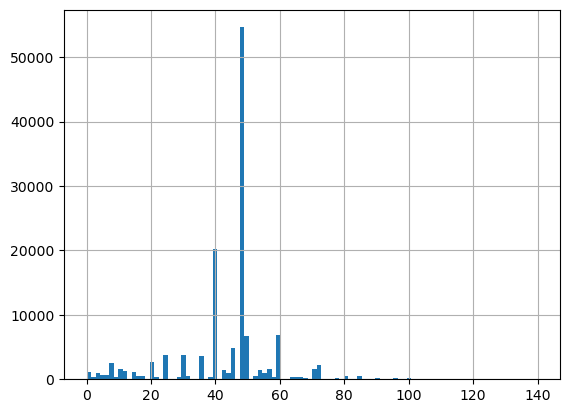

In [1467]:
personas.query("HORTRA != 'Blanco por pase'").HORTRA.hist(bins=100)

In [1470]:
(personas.query("HORTRA != 'Blanco por pase'").HORTRA <= 8).sum()

6254

In [1472]:
((personas.query("HORTRA != 'Blanco por pase'").HORTRA > 8) & (personas.query("HORTRA != 'Blanco por pase'").HORTRA <= 20)).sum()

8086

In [1474]:
((personas.query("HORTRA != 'Blanco por pase'").HORTRA > 20) & (personas.query("HORTRA != 'Blanco por pase'").HORTRA < 40)).sum()

12986

In [1485]:
pd.cut(
    personas.query("HORTRA != 'Blanco por pase'").HORTRA.astype(float),
    [0, 15, 35, 48.0001, np.inf],
    right=False
).value_counts(dropna=False)

HORTRA
[35.0, 48.0)    86245
[48.0, inf)     26344
[15.0, 35.0)    13785
[0.0, 15.0)      9546
NaN               337
Name: count, dtype: int64

In [1495]:
pd.cut(
    [48.1],
    [0, 15, 35, 48.1, np.inf],
    right=False
).value_counts(dropna=False)

[0.0, 15.0)     0
[15.0, 35.0)    0
[35.0, 48.1)    0
[48.1, inf)     1
Name: count, dtype: int64

In [1520]:
np.round(trips.query("Motivo == 'trabajo'").groupby(['HOGAR', 'HABITANTE']).stay_duration_h.sum()).value_counts()

stay_duration_h
 10.0    4246
 8.0     4090
 9.0     3552
 11.0    1614
 12.0    1476
 7.0     1141
 6.0      990
 5.0      585
 0.0      490
 4.0      417
 13.0     394
 2.0      192
 3.0      181
 14.0     177
 1.0       82
-16.0      75
-12.0      64
 15.0      57
-15.0      49
 16.0      43
-14.0      42
-13.0      23
-17.0      20
-11.0      18
 17.0      13
-10.0      12
-2.0       11
-3.0        6
-1.0        6
-18.0       5
-5.0        5
-8.0        4
 18.0       4
-7.0        4
-4.0        4
-19.0       3
-9.0        3
 19.0       1
Name: count, dtype: int64

## Imputation

Modeling options:
- Two independent model
- Sequential models
- Single model on joint categories
- Multioutput model

Independent, sequential and single joint model candidates:
- RF
- GBT
- DT

Multioutput model candidates, should output a joint probability distribution:
- RF (marginals)
- NN
- DT
- Py-boost

Outputs the joint distribution directly:
- BN

Should check if RF and NN can output a joint probability distributions, or if output are two marginal distributions.

Can the FACTORS from population synthesis be used for something?
Should imputation used them for weights?
If so, should each model be estimated by track? By municipality?
The original weights are valid at the municipality level.
Census can be reweighted by track.

It makes sense that the joint distribution of variables depends on the specific census track.
The fitted weights, thus, can inform of this change, so should be probably used.